In [2]:
# Copyright (c) 2014, Warren Weckesser
# All rights reserved.
# See the LICENSE file for license information.

import numpy as np
from scipy.integrate import odeint


# Tuple holding the major and minor versions of numpy.
_NUMPY_VERSION = tuple(int(d) for d in np.__version__.split('.')[:2])

if _NUMPY_VERSION >= (1, 7):
    _astype_kwargs = {'copy': False}
else:
    _astype_kwargs = {}


def _check_args(kwargs):
    """
    Check for arguments that are not supported with array differential
    equations.
    """
    _unsupported_odeint_args = ['col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintw for array differential equations." %
                         (bad_args[0],))


def _float64_view_of_complex128(z):
    """
    Convert z to a float64 view of a complex128 array.
    Convert z to an array that is at lead 1-d, with type np.complex128,
    and then return a np.float64 view of that array.
    """
    return np.atleast_1d(z).astype(np.complex128).view(np.float64)


def _complex_to_real_jac(jac):
    """
    Convert a complex array to a real array with doubled dimensions.
    Each element a+i*b of `jac` is expanded to the 2x2 real block:
        [[a, -b],
         [b,  a]].
    For example, the 2x2 complex matrix::
        [1+2j  3+4j]
        [5+6j  7+8j]
    becomes the real matrix::
        [1 -2  3 -4]
        [2  1  4  3]
        [5 -6  7 -8]
        [6  5  8  7]
    """
    real_jac = np.empty((2*jac.shape[0], 2*jac.shape[1]))
    real_jac[0::2, 0::2] = jac.real
    real_jac[1::2, 1::2] = jac.real
    real_jac[0::2, 1::2] = -jac.imag
    real_jac[1::2, 0::2] = jac.imag
    return real_jac


def _transform_banded_jac(bjac):
    """
    Convert a real matrix of the form (for example)
        [0 0 A B]        [0 0 0 B]
        [0 0 C D]        [0 0 A D]
        [E F G H]   to   [0 F C H]
        [I J K L]        [E J G L]
                         [I 0 K 0]
    That is, every other column is shifted up one.
    """
    # Shift every other column.
    newjac = np.zeros((bjac.shape[0] + 1, bjac.shape[1]))
    newjac[1:, ::2] = bjac[:, ::2]
    newjac[:-1, 1::2] = bjac[:, 1::2]
    return newjac


def odeintw(func, y0, t, **kwargs):
    """
    An odeint-like function for complex array-valued differential equations.
    The function `scipy.integrate.odeint` is a wrapper of the LSODA function
    for solving ordinary differential equations.  It is designed to handle
    a system of first order differential equations expressed as a vector
    function.  `odeint` does not handle equations with complex dependent
    variables, or array equations.
    `odeintw` is a wrapper of `odeint` that adds the ability to handle
    complex and array differential equations.  See the docstring of odeint
    for an explanation of its arguments.
    Unlike odeint, all arguments after the first three position arguments
    `func` (the system definition function), `y0` (the initial condition)
    and `t` (the time values) must be given as keyword arguments.
    Initial conditions
    ------------------
    The initial condition `y0` given to `odeintw` determines the type of the
    solution that is generated.  The data type and shape of the value
    returned by `func` must match those of the initial condition.
    If the solution is to be complex, the initial condition must be complex.
    To solve a complex differential equation with real initial conditions,
    give complex initial conditions with zero imaginary parts.
    Similarly, the shape of the solution of a matrix differential equation
    is determined by the shape of the initial condition.  For example, if
    the initial condition has shape (2,3), then `func` must return a numpy
    array (or something array-like) that has shape (2,3).
    Special handling of Jacobian arguments
    --------------------------------------
    The argument `Dfun` may be used with array equations.  If `shp` is the
    shape of the array, then the shape of the Jacobian array returned by
    `Dfun` must be ``shp + shp``.  For example, if the array is 2-d `F`,
        jac[m, n, i, j] holds dF[m,n]/da[i,j]
    `Dfun` may also be used with complex equations.  However, if the
    functions computed by `func` are not complex differentiable, the
    Jacobian function should not be used.  To use the Jacobian argument in
    this case, the equations should be rewritten as a system of real
    equations for the real and imaginary parts of the solution.  For
    example, the conjugation operation is not complex differentiable, so
    to use an explicit Jacobian for the complex scalar equation
        dz/dt = z.conj(),
    the equation must be written as
        dx/dt = x
        dy/dt = -y
    Then the Jacobian of the real system is [[1, 0], [0, -1]].
    If `Dfun` is not given as an argument, the system may be left as a
    complex differential equation.
    In the case of arrays with dimension 2 or more, the odeint arguments
    `col_deriv`, `ml` and `mu` can not be used.
    Complex array equations are handled, but to use `Dfun`, the same
    requirement on the complex differentiability of the components
    holds.
    """

    full_output = kwargs.get('full_output', False)
    tfirst = kwargs.get('tfirst', False)
    Dfun = kwargs.pop('Dfun', None)

    y0 = np.atleast_1d(y0)
    shape = y0.shape

    if y0.ndim == 1:
        func1 = func
        jacfunc1 = Dfun
    else:
        # y0 has dimension greater than 1.
        _check_args(kwargs)

        # Flatten y0, and create a wrapper for func that can be used
        # by odeint.
        y0 = y0.ravel()

        if tfirst:
            def vecfunc(t, y, *args):
                a = y.reshape(shape)
                dadt = func(t, a, *args)
                return np.asarray(dadt).ravel()
        else:
            def vecfunc(y, t, *args):
                a = y.reshape(shape)
                dadt = func(a, t, *args)
                return np.asarray(dadt).ravel()

        func1 = vecfunc

        if Dfun is not None:

            if tfirst:
                def jacfunc(t, y, *args):
                    a = y.reshape(shape)
                    jac = Dfun(t, a, *args)
                    return np.asarray(jac).reshape(y0.size, y0.size)
            else:
                def jacfunc(y, t, *args):
                    a = y.reshape(shape)
                    jac = Dfun(a, t, *args)
                    return np.asarray(jac).reshape(y0.size, y0.size)

            jacfunc1 = jacfunc
        else:
            jacfunc1 = None

    if not np.iscomplexobj(y0):
        y0 = y0.astype(np.float64, **_astype_kwargs)
        func2 = func1
        jacfunc2 = jacfunc1
    else:
        # y0 is complex.
        col_deriv = kwargs.pop('col_deriv', False)
        ml = kwargs.pop('ml', None)
        mu = kwargs.pop('mu', None)
        kwargs['ml'] = None if ml is None else 1 + 2*ml
        kwargs['mu'] = None if mu is None else 1 + 2*mu

        # Cast y0 to np.complex128.
        y0 = y0.astype(np.complex128, **_astype_kwargs)

        # realfunc is a wrapper of the user's function that can be
        # used by odeint.
        if tfirst:
            def realfunc(t, y, *args):
                z = y.view(np.complex128)
                dzdt = func1(t, z, *args)
                # func1 might return a python list, or a scalar, so convert
                # it to a float64 view of a complex128 array.
                dydt = _float64_view_of_complex128(dzdt)
                return dydt
        else:
            def realfunc(y, t, *args):
                z = y.view(np.complex128)
                dzdt = func1(z, t, *args)
                # func1 might return a python list, or a scalar, so convert
                # it to a float64 view of a complex128 array.
                dydt = _float64_view_of_complex128(dzdt)
                return dydt

        func2 = realfunc

        if jacfunc1 is not None:

            if tfirst:
                def jacfuncz(t, y, *args):
                    z = y.view(np.complex128)
                    jac = jacfunc1(t, z, *args)
                    if col_deriv:
                        # If col_deriv is True, transpose the result returned
                        # by jacfunc1, and continue as if col_deriv was False.
                        jac = jac.T
                    # Convert jac to real_jac, an array in which each complex
                    # value a+i*b in jac is expanded to the 2x2 array
                    # [[a, -b], [b, a]].
                    real_jac = _complex_to_real_jac(jac)
                    if ml is not None or mu is not None:
                        # Banded; shift every other column up one.
                        real_jac = _transform_banded_jac(real_jac)
                    return real_jac
            else:
                def jacfuncz(y, t, *args):
                    z = y.view(np.complex128)
                    jac = jacfunc1(z, t, *args)
                    if col_deriv:
                        # If col_deriv is True, transpose the result returned
                        # by jacfunc1, and continue as if col_deriv was False.
                        jac = jac.T
                    # Convert jac to real_jac, an array in which each complex
                    # value  a+i*b in jac is expanded to the 2x2 array
                    # [[a, -b], [b, a]].
                    real_jac = _complex_to_real_jac(jac)
                    if ml is not None or mu is not None:
                        # Banded; shift every other column up one.
                        real_jac = _transform_banded_jac(real_jac)
                    return real_jac

            jacfunc2 = jacfuncz
        else:
            jacfunc2 = None

    # Call scipy.integrate.odeint with our wrapper.
    result = odeint(func2, y0.view(np.float64), t, Dfun=jacfunc2, **kwargs)

    if full_output:
        sol, infodict = result
    else:
        sol = result

    if np.iscomplexobj(y0):
        # Restore the complex view.
        sol = sol.view(np.complex128)

    # Restore the shape.
    sol = sol.reshape(-1, *shape)

    if full_output:
        result = (sol, infodict)
    else:
        result = sol
    return result

EXAMPLE ONE

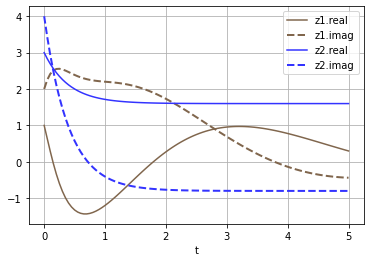

In [5]:
# Copyright (c) 2014, Warren Weckesser
# All rights reserved.
# See the LICENSE file for license information.

import numpy as np
import matplotlib.pyplot as plt



# Generate a solution to:
#     dz1/dt = -z1 * (K - z2)
#     dz2/dt = L - M*z2
# K, L and M are fixed parameters.  z1(t) and z2(t) are complex-
# valued functions of t.

# Define the right-hand-side of the differential equation.
def zfunc(z, t, K, L, M):
    z1, z2 = z
    return [-z1 * (K - z2), L - M*z2]


def zjac(z, t, K, L, M):
    z1, z2 = z
    jac = np.array([[z2 - K, z1], [0, -M]])
    return jac


# Set up the inputs and call odeintw to solve the system.
z0 = np.array([1+2j, 3+4j])
t = np.linspace(0, 5, 101)
K = 2
L = 4 - 2j
M = 2.5
z, infodict = odeintw(zfunc, z0, t, args=(K, L, M), Dfun=zjac,
                      full_output=True)

plt.figure(1)
plt.clf()
color1 = (0.5, 0.4, 0.3)
color2 = (0.2, 0.2, 1.0)
plt.plot(t, z[:, 0].real, color=color1, label='z1.real', linewidth=1.5)
plt.plot(t, z[:, 0].imag, '--', color=color1, label='z1.imag', linewidth=2)
plt.plot(t, z[:, 1].real, color=color2, label='z2.real', linewidth=1.5)
plt.plot(t, z[:, 1].imag, '--', color=color2, label='z2.imag', linewidth=2)
plt.xlabel('t')
plt.grid(True)
plt.legend(loc='best')

plt.show()

EXAMPLE TWO

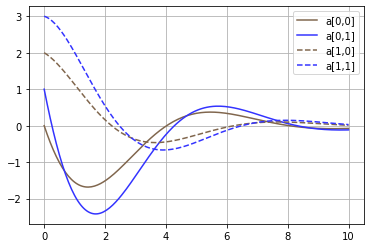

In [6]:
# Copyright (c) 2014, Warren Weckesser
# All rights reserved.
# See the LICENSE file for license information.

import numpy as np
import matplotlib.pyplot as plt


# Matrix differential equation
#     da/dt = c*a
# where a and c are (for example) 2x2 matrices.

def asys(a, t, c):
    return c.dot(a)


def ajac(a, t, c):
    # asys returns [[F[0,0](a,t), F[0,1](a,t),
    #                F[1,0](a,t), F[1,1](a,t)]]
    # This function computes jac[m, n, i, j]
    # jac[m, n, i, j] holds dF[m,n]/da[i,j]
    jac = np.zeros((2, 2, 2, 2))
    jac[0, 0, 0, 0] = c[0, 0]
    jac[0, 0, 1, 0] = c[0, 1]
    jac[0, 1, 0, 1] = c[0, 0]
    jac[0, 1, 1, 1] = c[0, 1]
    jac[1, 0, 0, 0] = c[1, 0]
    jac[1, 0, 1, 0] = c[1, 1]
    jac[1, 1, 0, 1] = c[1, 0]
    jac[1, 1, 1, 1] = c[1, 1]

    return jac


c = np.array([[-0.5, -1.25],
              [ 0.5, -0.25]])
t = np.linspace(0, 10, 201)

# a0 is the initial condition.
a0 = np.array([[0.0, 1.0],
               [2.0, 3.0]])

sol = odeintw(asys, a0, t, Dfun=ajac, args=(c,))

plt.figure(1)
plt.clf()
color1 = (0.5, 0.4, 0.3)
color2 = (0.2, 0.2, 1.0)
plt.plot(t, sol[:, 0, 0], color=color1, label='a[0,0]')
plt.plot(t, sol[:, 0, 1], color=color2, label='a[0,1]')
plt.plot(t, sol[:, 1, 0], '--', color=color1, linewidth=1.5, label='a[1,0]')
plt.plot(t, sol[:, 1, 1], '--', color=color2, linewidth=1.5, label='a[1,1]')
plt.legend(loc='best')
plt.grid(True)
plt.show()